# Direct S3 Access GEDI L4A from the NASA Earthdata Cloud

GEDI L4A Datasets are available through NASA's Earthdata Cloud. In this tutorial, we will retrieve **Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD)**{cite}`dubayah2022` dataset from the Earthdata Cloud using direct S3 access.

NASA Earthdata on Cloud is always free and accessible via either HTTPS or direct [S3](https://aws.amazon.com/s3/) bucket access. With direct S3 access, you can bring your "code to the data", making your processing faster and scalable. Direct S3 access to NASA Earthdata on Cloud is only available if your Amazon Web Services ([AWS](https://aws.amazon.com/)) instance is set up in the `us-west-2` region. If you are new to the Earthdata Cloud, these NASA Earthdata [primers](https://www.earthdata.nasa.gov/learn/tutorials/cloud-primer-amazon-web-services) and [tutorials](https://www.earthdata.nasa.gov/learn/tutorials/cloud-computing-earth-scientists) are good resources to get you started. 

You can access jupyter notebook within your own [AWS EC2](https://aws.amazon.com/ec2/) instance. Alternatively, you can use [Amazon SageMaker Studio Lab](https://studiolab.sagemaker.aws/) to run this jupyter notebook. SageMaker Studio Lab is a [free service](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-lab.html) that gives access to AWS compute resources and direct S3 access to datasets in the NASA Earthdata Cloud through a JupyterLab environment.

```{admonition} Learning Objectives
- Download and subset GEDI L4A datasets using direct S3 access
```

## Requirements
This tutorial should be run on the Cloud, such as a Jupyter Lab instance running in AWS `us-west 2` region. Additional prerequisites for running this Jupyter notebook are provided [here](https://ornldaac.github.io/gedi_tutorials/prerequisites). 

In [1]:
# import python modules
import h5py
import earthaccess
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.ops import orient
from pqdm.threads import pqdm

## 1. Polygonal Area of Interest

We will read an area within the [Harvard Forests](https://harvardforest.fas.harvard.edu/) as a GeoJSON file. The Harvard Forests is one of the most extensively studied ecological sites in the United States.

If an area of interest is already defined as a polygon, the polygon file (geojson, shapefile, or kml) can be used to find overlapping GEDI L4A files. More details about this capability are described on [this page](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#c-shapefile).

In [2]:
# read geojson
poly = gpd.read_file("polygons/harvard.json")
poly.explore(color='red',  fill=False)

## 2. Searching GEDI L4A Files

We will use the `earthaccess` module to query spatially overlapping GEDI L4A granules. 

In [3]:
# bounding lon, lat as a list of tuples
bounds = poly.geometry.apply(orient, args=(1,))
# simplifying the polygon to bypass the coordinates 
# limit of the CMR with a tolerance of .01 degrees
xy = bounds.simplify(0.01).get_coordinates()

granules = earthaccess.search_data(
    doi="10.3334/ORNLDAAC/2056", # GEDI L4A DOI 
    polygon=list(zip(xy.x, xy.y))
)
print(f"Total granules found: {len(granules)}")

Total granules found: 31


Let’s retrieve direct s3 links from the above earthaccess `search_data` results.

In [4]:
granule_arr=[]
for g in granules:
    granule_arr.append(g.data_links(access="direct")[0])

Now, the `granule_arr` contains a list of `s3` granule links, starting with `s3://`. We can print the first two items of the `granule_arr`.

In [5]:
granule_arr = sorted(granule_arr)
granule_arr[:2]

['s3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2019229131935_O03846_02_T03642_02_002_02_V002.h5',
 's3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2019246121050_O04109_03_T04380_02_002_02_V002.h5']

Let's plot the monthly number of granules overlapping the above area within the Harvard Forest.

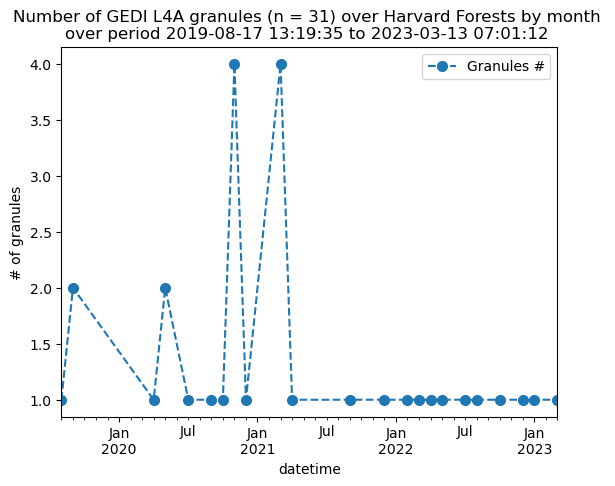

In [6]:
fmt = '%Y%j%H%M%S' # GEDI granule name has date time as YYYYDDDHHMMSS
granule_dt = [g.split('/')[-1].split('_')[2] for g in granule_arr]
df = pd.DataFrame(list(zip(granule_dt, granule_arr)), columns =['datetime', 'Granules #'])

df['datetime'] = pd.to_datetime(df['datetime'], format=fmt)
df.set_index('datetime', inplace=True)

# plotting a monthly granule count plot
title = f'''Number of GEDI L4A granules (n = {len(granule_arr)}) over Harvard Forests by month 
over period {df.index.min()} to {df.index.max()} '''
ax = df.groupby(df.index.to_period('M')).agg('count').plot(style='o--', markersize=7, title=title)
ax.set_ylabel("# of granules")
plt.show()

As we see in the figure above, over the Harvard Forest area, some months do not have overlapping GEDI granules while some months have up to four granules.

## 3. Direct S3 access
We recommend using `earthaccess` to download GEDI data granules from the NASA Earthdata. You will first need to authenticate your [Earthdata Login (EDL)](https://urs.earthdata.nasa.gov/) information using the `earthaccess` python library as follows:

In [7]:
# works if the EDL login already been persisted to a netrc
try:
    auth = earthaccess.login(strategy="netrc")
except FileNotFoundError:
    # ask for EDL credentials and persist them in a .netrc file
    auth = earthaccess.login(strategy="interactive", persist=True)

We will use [S3Fs](https://s3fs.readthedocs.io/),  Pythonic file interface to S3 for file-system style access. We will now retrieve S3Fs class `S3FileSystem` using `earthaccess` module.

In [8]:
fs_s3 = earthaccess.get_s3_filesystem(results=granules)

For this tutorial, we will be retrieving the AGBD variables `agbd` and `l4_quality_flag`, in addition to the variables that provide geolocation (`lat_lowestmode`, `lon_lowestmode`, `elev_lowestmode`) and shot identifier (`shot_number`).

In [9]:
def gedi_l4a_subset(gr):
    headers = ['lat_lowestmode', 'lon_lowestmode', 'elev_lowestmode', 'shot_number']
    variables = ['agbd', 'l4_quality_flag']
    headers.extend(variables)
    polygon = gpd.read_file("polygons/harvard.json")
    dfs = []
    with h5py.File(gr) as hf:
        beam_names = filter(lambda x: x.startswith('BEAM'), list(hf.keys()))
        for var in beam_names:
            # create pandas dataframe
            df = pd.DataFrame({'lat_lowestmode': hf[var]['lat_lowestmode'],
                               'lon_lowestmode': hf[var]['lon_lowestmode']})
            # create geopandas dataframe
            gdf = gpd.GeoDataFrame(df, crs="EPSG:4326",
                                   geometry=gpd.points_from_xy(df.lon_lowestmode,
                                                               df.lat_lowestmode))
            # subset within the polygon
            poly_gdf = gpd.sjoin(gdf, polygon, predicate='within')
            if not poly_gdf.empty:
                for v in headers[2:]:
                    poly_gdf[v] = None
                # retrieving variables of interest, agbd, l4_quality_flag in this case.
                # We are only retreiving the shots within subset area.
                for _, df_gr in poly_gdf.groupby((poly_gdf.index.to_series().diff() > 1).cumsum()):
                    i = df_gr.index.min()
                    j = df_gr.index.max()
                    for v in variables:
                        poly_gdf.loc[i:j, (v)] = hf[var][v][i:j+1]

                # appending to the output file if valid agbd
                poly_gdf = poly_gdf[poly_gdf['agbd'] != -9999]
                if not poly_gdf.empty:
                    dfs.append(poly_gdf)
                
    if dfs:
        return pd.concat(dfs)
    
result = pqdm(earthaccess.open(granules), gedi_l4a_subset, n_jobs=8)
l4a_gdf = pd.concat([x for x in result if x is not None])

QUEUEING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/31 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/31 [00:00<?, ?it/s]

We will now plot the AGBD (mg/ha-1) values of the footprints on a map.

In [10]:
xyz = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
attr = "ESRI"
l4a_gdf['agbd'] = l4a_gdf['agbd'].astype(float)
l4a_gdf[['agbd', 'l4_quality_flag', 'geometry']].explore("agbd", cmap = "YlGn", 
                                                         tiles=xyz, attr=attr, legend=True)

In [11]:
# (optional) export to csv
l4a_gdf.to_csv('poly_subset.csv', index=False)

## References
```{bibliography}
:style: plain
:filter: docname in docnames
```